SETUP:
1. Download input_images from our drive folder and upload them to colab's runtime files

In [ ]:
import torch
import os
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
# setup (visualization library only supports CPU)
device = torch.device('cpu')

In [ ]:
# CNN Visualizer code: (https://github.com/utkuozbulak/pytorch-cnn-visualizations)


In [ ]:
# misc_functions.py

"""
Created on Thu Oct 21 11:09:09 2017
@author: Utku Ozbulak - github.com/utkuozbulak
"""
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.png')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def apply_heatmap(R, sx, sy):
    """
        Heatmap code stolen from https://git.tu-berlin.de/gmontavon/lrp-tutorial
        This is (so far) only used for LRP
    """
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx, sy))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    heatmap = plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    return heatmap
    # plt.show()


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('input_images/snake.png', 56),
                    ('input_images/cat_dog.png', 243),
                    ('input_images/spider.png', 72),
                    ('input_images/snake_img_spider_class.png', 72),
                    ('input_images/spider_img_snake_class.png', 56))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.resnet50(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

Next Steps (discussed between Sohum and Mohit):
1. Pick a pretrainted model and dataset
2. Find a correctly classified input
3. Generate a perturbed input [example](https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8)
4. Provide visualizations of these inputs as they go through the pretrained model
5. Report findings about where they diverge, where the outputs look very different
6. Organize results in a way that communicates this understanding

In [ ]:
target_example = 0  # Snake
(snake_image, snake_tensor, snake_class, file_name_to_export, pretrained_model) = get_example_params(target_example)

target_example = 2 # Spider
(spider_image, spider_tensor, spider_class, file_name_to_export, pretrained_model) = get_example_params(target_example)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

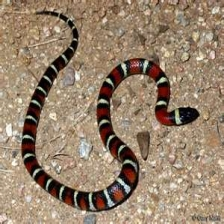

In [ ]:
snake_image

In [ ]:
snake_tensor.shape


torch.Size([1, 3, 224, 224])

In [ ]:
with torch.no_grad():
    output = pretrained_model(snake_tensor)


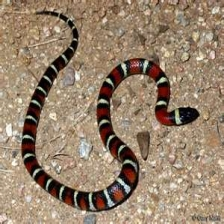

In [ ]:
img_from_arr = recreate_image(snake_tensor)
Image.fromarray(img_from_arr)

In [ ]:
perturbed_snake_img = torch.clone(snake_tensor)

noise = (torch.rand(1, 3, 224, 224) - 0.5) * 4  # CHANGE THIS VALUE TO ADD MORE / LESS PERTURBATION

noise.shape
perturbed_snake_img.shape

perturbed_snake_img = torch.add(perturbed_snake_img, noise)

with torch.no_grad():
    output = pretrained_model(perturbed_snake_img)

torch.argmax(output[0]).item()

463

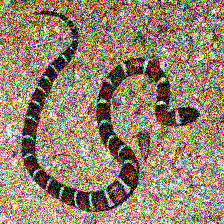

In [ ]:
perturbed_arr = recreate_image(perturbed_snake_img)
Image.fromarray(perturbed_arr)

In [ ]:
# sohum's experimentation with generating adversarial example from image of another class (use snake image to generate spider classification)

import os
import numpy as np

import torch
from torch.optim import SGD
from torchvision import models

class ClassSpecificImageGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent
    """
    def __init__(self, model, starting_image, target_class):
        self.mean = [-0.485, -0.456, -0.406]
        self.std = [1/0.229, 1/0.224, 1/0.225]
        self.model = model
        self.model.eval()
        self.target_class = target_class
        # Generate a random image
        self.created_image = recreate_image(starting_image)
        # Create the folder to export images if not exists
        if not os.path.exists('../generated/class_'+str(self.target_class)):
            os.makedirs('../generated/class_'+str(self.target_class))

    def generate(self, iterations=150):
        """Generates class specific image
        Keyword Arguments:
            iterations {int} -- Total iterations for gradient ascent (default: {150})
        Returns:
            np.ndarray -- Final maximally activated class image
        """
        initial_learning_rate = 6
        for i in range(1, iterations):
            # Process image and return variable
            self.processed_image = preprocess_image(self.created_image, False)

            # Define optimizer for the image
            optimizer = SGD([self.processed_image], lr=initial_learning_rate)
            # Forward
            output = self.model(self.processed_image)
            # Target specific class
            class_loss = -output[0, self.target_class]

            if i % 10 == 0 or i == iterations-1:
                print('Iteration:', str(i), 'Loss',
                      "{0:.2f}".format(class_loss.data.numpy()))
            # Zero grads
            self.model.zero_grad()
            # Backward
            class_loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # if i % 10 == 0 or i == iterations-1:
            #     # Save image
            #     im_path = '../generated/class_'+str(self.target_class)+'/c_'+str(self.target_class)+'_'+'iter_'+str(i)+'.png'
            #     save_image(self.created_image, im_path)

        return self.processed_image

In [ ]:
# Create spider classification from snake image

target_class = 72  # spider
pretrained_model = models.resnet50(pretrained=True)
csig = ClassSpecificImageGeneration(pretrained_model, snake_tensor, target_class) # prep_img is snake image
snake_img_spider_class_tensor = csig.generate(iterations=10) # may want to tune number of iterations so it looks more like a snake

Iteration: 9 Loss -17.74


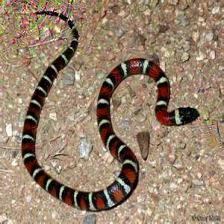

In [ ]:
snake_img_spider_class_np = recreate_image(snake_img_spider_class_tensor)
recreated_im = Image.fromarray(snake_img_spider_class_np)
save_image(recreated_im, 'input_images/snake_img_spider_class.png')
recreated_im

In [ ]:
with torch.no_grad():
    output = pretrained_model(snake_img_spider_class_tensor)
torch.argmax(output[0]).item() # if the output is 72, then the snake (56) image has been used to create the spider (72) classification

72

In [ ]:
# Create snake classification from spider image
target_class = 56
pretrained_model = models.resnet50(pretrained=True)
csig = ClassSpecificImageGeneration(pretrained_model, spider_tensor, target_class)
spider_img_snake_class_tensor = csig.generate(iterations=3)

Iteration: 2 Loss -8.86


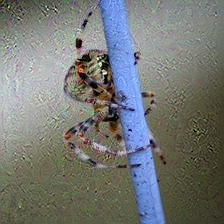

In [ ]:
spider_img_snake_class_np = recreate_image(spider_img_snake_class_tensor)
recreated_im = Image.fromarray(spider_img_snake_class_np)
save_image(recreated_im, 'input_images/spider_img_snake_class.png')
recreated_im

In [ ]:
with torch.no_grad():
    output = pretrained_model(spider_img_snake_class_tensor)
torch.argmax(output[0]).item() # if the output is 56, then the spider (72) image has been used to create the snake (56) classification

56

At this point in the code, there are 5 tensors (all pytorch tensors):
1. snake_tensor - the normal snake image
2. spider_tensor - the normal spider image
3. snake_img_spider_class_tensor - the image of a snake that is classified as a spider
4. spider_img_snake_class_tensor - the image of a spider that is classified as a snake
5. perturbed_snake_img - the naively perturbed snake image that is categorized incorrectly

1-4 are the ones we should visualize, as they are more interesting. 5 was an initial attempt to create an adversarial example, but the visualization's likely won't show much.

## CNN Layer Vizualization

In [ ]:
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## AlexNet

In [ ]:
import torch
from torch.autograd import Variable
from torch.optim import SGD
import os
from matplotlib.pyplot import imshow



class InvertedRepresentation():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        if not os.path.exists('../vizualizations'):
            os.makedirs('../vizualizations')

    def alpha_norm(self, input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm

    def total_variation_norm(self, input_matrix, beta):
        """
            Total variation norm is the second norm in the paper
            represented as R_V(x)
        """
        to_check = input_matrix[:, :-1, :-1]  # Trimmed: right - bottom
        one_bottom = input_matrix[:, 1:, :-1]  # Trimmed: top - right
        one_right = input_matrix[:, :-1, 1:]  # Trimmed: top - right
        total_variation = (((to_check - one_bottom)**2 +
                            (to_check - one_right)**2)**(beta/2)).sum()
        return total_variation

    def euclidian_loss(self, org_matrix, target_matrix):
        """
            Euclidian loss is the main loss function in the paper
            ||fi(x) - fi(x_0)||_2^2& / ||fi(x_0)||_2^2
        """
        distance_matrix = target_matrix - org_matrix
        euclidian_distance = self.alpha_norm(distance_matrix, 2)
        normalized_euclidian_distance = euclidian_distance / self.alpha_norm(org_matrix, 2)
        return normalized_euclidian_distance
    
    def get_output_from_specific_layer(self, x, layer_id):
        """
            Saves the output after a forward pass until nth layer
            This operation could be done with a forward hook too
            but this one is simpler (I think)
        """
        layer_output = None
        for index, layer in enumerate(self.model.features):
            x = layer(x)
            if str(index) == str(layer_id):
                layer_output = x[0]
                break
        return layer_output

    def generate_inverted_image_specific_layer(self, input_image, img_size, target_class, file_name_to_export, target_layer=3):
        # Generate a random image which we will optimize
        opt_img = Variable(1e-1 * torch.randn(1, 3, img_size, img_size), requires_grad=True)
        # Define optimizer for previously created image
        optimizer = SGD([opt_img], lr=1e4, momentum=0.9)
        # Get the output from the model after a forward pass until target_layer
        # with the input image (real image, NOT the randomly generated one)
        input_image_layer_output = \
            self.get_output_from_specific_layer(input_image, target_layer)

        # Alpha regularization parametrs
        # Parameter alpha, which is actually sixth norm
        alpha_reg_alpha = 6
        # The multiplier, lambda alpha
        alpha_reg_lambda = 1e-7

        # Total variation regularization parameters
        # Parameter beta, which is actually second norm
        tv_reg_beta = 2
        # The multiplier, lambda beta
        tv_reg_lambda = 1e-8

        recreated_im = None
        for i in range(201):
            optimizer.zero_grad()
            # Get the output from the model after a forward pass until target_layer
            # with the generated image (randomly generated one, NOT the real image)
            output = self.get_output_from_specific_layer(opt_img, target_layer)
            # Calculate euclidian loss
            euc_loss = 1e-1 * self.euclidian_loss(input_image_layer_output.detach(), output)
            # Calculate alpha regularization
            reg_alpha = alpha_reg_lambda * self.alpha_norm(opt_img, alpha_reg_alpha)
            # Calculate total variation regularization
            reg_total_variation = tv_reg_lambda * self.total_variation_norm(opt_img,
                                                                            tv_reg_beta)
            # Sum all to optimize
            loss = euc_loss + reg_alpha + reg_total_variation
            # Step
            loss.backward()
            optimizer.step()
            # Generate image every 5 iterations
                

            # Reduce learning rate every 40 iterations
            if i % 40 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 1/10
            
            if i == 200:
              recreated_im = recreate_image(opt_img)
              if not os.path.exists('../vizualizations/'+str(file_name_to_export)):
                os.makedirs('../vizualizations/'+str(file_name_to_export))
              im_path = '../vizualizations/'+str(file_name_to_export)+'/Sequential_Layer_' + str(target_layer)+'.jpg'
              save_image(recreated_im, im_path)


if __name__ == '__main__':
    # Get params
    for target_example in [0, 2, 3, 4]:
      (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =get_example_params(target_example)

      inverted_representation = InvertedRepresentation(pretrained_model)
      image_size = 224  # width & height
      for target_layer in [2, 5, 8, 11]:
        inverted_representation.generate_inverted_image_specific_layer(prep_img,
                                                                      image_size,
                                                                      target_class, file_name_to_export, target_layer)

In [ ]:
!zip -r /content/file.zip /vizualizations/

## ResNet

In [ ]:
import torch
from torch.autograd import Variable
from torch.optim import SGD
import os
from matplotlib.pyplot import imshow



class InvertedRepresentation():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        if not os.path.exists('../vizualizations'):
            os.makedirs('../vizualizations')

    def alpha_norm(self, input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm

    def total_variation_norm(self, input_matrix, beta):
        """
            Total variation norm is the second norm in the paper
            represented as R_V(x)
        """
        to_check = input_matrix[:, :-1, :-1]  # Trimmed: right - bottom
        one_bottom = input_matrix[:, 1:, :-1]  # Trimmed: top - right
        one_right = input_matrix[:, :-1, 1:]  # Trimmed: top - right
        total_variation = (((to_check - one_bottom)**2 +
                            (to_check - one_right)**2)**(beta/2)).sum()
        return total_variation

    def euclidian_loss(self, org_matrix, target_matrix):
        """
            Euclidian loss is the main loss function in the paper
            ||fi(x) - fi(x_0)||_2^2& / ||fi(x_0)||_2^2
        """
        distance_matrix = target_matrix - org_matrix
        euclidian_distance = self.alpha_norm(distance_matrix, 2)
        normalized_euclidian_distance = euclidian_distance / self.alpha_norm(org_matrix, 2)
        return normalized_euclidian_distance
    
    def get_output_from_specific_layer(self, x, layer_id):
        """
            Saves the output after a forward pass until nth layer
            This operation could be done with a forward hook too
            but this one is simpler (I think)
        """

        layer_output = None
        for index, layer in enumerate(nn.Sequential(*(list((models.resnet50(pretrained=True)).children())[:-(layer_id+1)]))):
            x = layer(x)
        layer_output = x[0]
        return(layer_output)

    def generate_inverted_image_specific_layer(self, input_image, img_size, target_class, file_name_to_export, target_layer=3):
        # Generate a random image which we will optimize
        opt_img = Variable(1e-1 * torch.randn(1, 3, img_size, img_size), requires_grad=True)
        # Define optimizer for previously created image
        optimizer = SGD([opt_img], lr=1e4, momentum=0.9)
        # Get the output from the model after a forward pass until target_layer
        # with the input image (real image, NOT the randomly generated one)
        input_image_layer_output = \
            self.get_output_from_specific_layer(input_image, target_layer)

        # Alpha regularization parametrs
        # Parameter alpha, which is actually sixth norm
        alpha_reg_alpha = 6
        # The multiplier, lambda alpha
        alpha_reg_lambda = 1e-7

        # Total variation regularization parameters
        # Parameter beta, which is actually second norm
        tv_reg_beta = 2
        # The multiplier, lambda beta
        tv_reg_lambda = 1e-8

        recreated_im = None
        optimizer.zero_grad()
        # Get the output from the model after a forward pass until target_layer
        # with the generated image (randomly generated one, NOT the real image)
        output = self.get_output_from_specific_layer(opt_img, target_layer)
        # Calculate euclidian loss
        euc_loss = 1e-1 * self.euclidian_loss(input_image_layer_output.detach(), output)
        # Calculate alpha regularization
        reg_alpha = alpha_reg_lambda * self.alpha_norm(opt_img, alpha_reg_alpha)
        # Calculate total variation regularization
        reg_total_variation = tv_reg_lambda * self.total_variation_norm(opt_img,
                                                                        tv_reg_beta)
        # Sum all to optimize
        loss = euc_loss + reg_alpha + reg_total_variation
        # Step
        loss.backward()
        optimizer.step()
            # Generate image every 5 iterations
                

            # Reduce learning rate every 40 iterations
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 1/10

        recreated_im = recreate_image(opt_img)
        if not os.path.exists('../vizualizations/'+str(file_name_to_export)):
          os.makedirs('../vizualizations/'+str(file_name_to_export))
        im_path = '../vizualizations/'+str(file_name_to_export)+'/Sequential_Layer_' + str(target_layer)+'.jpg'
        save_image(recreated_im, im_path)


if __name__ == '__main__':
    # Get params
    for target_example in [0, 2, 3, 4]:
      (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =get_example_params(target_example)

      inverted_representation = InvertedRepresentation(pretrained_model)
      image_size = 224  # width & height

      for target_layer in [4, 5, 6, 7]:
        inverted_representation.generate_inverted_image_specific_layer(prep_img,
                                                                      image_size,
                                                                      target_class, file_name_to_export, target_layer)

In [ ]:
!zip -r /content/file.zip /vizualizations/

  adding: vizualizations/ (stored 0%)
  adding: vizualizations/spider/ (stored 0%)
  adding: vizualizations/spider/Sequential_Layer_6.jpg (deflated 5%)
  adding: vizualizations/spider/Sequential_Layer_7.jpg (deflated 4%)
  adding: vizualizations/spider/Sequential_Layer_4.jpg (deflated 1%)
  adding: vizualizations/spider/Sequential_Layer_5.jpg (deflated 3%)
  adding: vizualizations/snake_img_spider_class/ (stored 0%)
  adding: vizualizations/snake_img_spider_class/Sequential_Layer_6.jpg (deflated 4%)
  adding: vizualizations/snake_img_spider_class/Sequential_Layer_7.jpg (deflated 3%)
  adding: vizualizations/snake_img_spider_class/Sequential_Layer_4.jpg (deflated 1%)
  adding: vizualizations/snake_img_spider_class/Sequential_Layer_5.jpg (deflated 4%)
  adding: vizualizations/spider_img_snake_class/ (stored 0%)
  adding: vizualizations/spider_img_snake_class/Sequential_Layer_6.jpg (deflated 5%)
  adding: vizualizations/spider_img_snake_class/Sequential_Layer_7.jpg (deflated 4%)
  adding: